In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
from petTOAD_analyses_helpers import *

In [3]:
def write_corr_pval(df, x_col, mod_diff, ax, fontsize, correct_age):
    def format_pval_corr(p):
        if 0.04 < p < 0.05:
            return f"p = {p:.3f}"
        if p < 0.01:
            return f"p < 0.01"
        else:
            return f"p = {p:.2f}"

    if not correct_age:
        r, p = spearmanr(df[x_col], df[mod_diff])
    else:
        pc = partial_corr(
            data=df, x=x_col, y=mod_diff, covar=["Age"], method="spearman"
        )
        r = pc["r"].values[0]
        p = pc["p-val"].values[0]

    ax.text(
        0.05,
        0.73,
        f"r={r:.2f}\n{format_pval_corr(p)}",
        transform=ax.transAxes,
        fontsize=fontsize,
    )


def update_legend_model_type_comparison(ax):
    model_types = [
        "Homogeneous",
        "Heterogeneous",
        "Random",
    ]
    model_colors = [
        pal[1]
        for pal in [
            sns.color_palette("pastel"),
            sns.color_palette("deep"),
            sns.color_palette("muted"),
        ]
    ]
    model_colors1 = [
        pal[2]
        for pal in [
            sns.color_palette("pastel"),
            sns.color_palette("deep"),
            sns.color_palette("muted"),
        ]
    ]

    # Create legend elements
    legend_elements = []
    for model_type, color in zip(model_types, model_colors):
        # Create two squares for each model type
        handle1 = plt.Line2D(
            [0], [0], marker="s", color="w", markerfacecolor=color, markersize=8
        )
    for model_type, color in zip(model_types, model_colors1):
        handle2 = plt.Line2D(
            [0], [0], marker="s", color="w", markerfacecolor=color, markersize=8
        )
        legend_elements.append((handle1, handle2))
    ax.legend(
        handles=legend_elements,
        title="Model Type",
        labels=model_types,
        handler_map={tuple: HandlerTuple(ndivide=None)},
        bbox_to_anchor=(1.1, 0.75),
    )


def update_boxplot_color(ax):
    palette_hom = sns.color_palette("pastel")
    palette_het = sns.color_palette("deep")
    palette_rand = sns.color_palette("muted")

    combs = [(0, 1, 3, 5), (0, 6, 7, 8)]

    for i, comb in enumerate(combs):
        box_hom = ax.patches[comb[0]]
        box_het = ax.patches[comb[1]]
        box_rand = ax.patches[comb[2]]

        box_hom.set_facecolor(palette_hom[i + 1])
        box_het.set_facecolor(palette_het[i + 1])
        box_rand.set_facecolor(palette_rand[i + 1])


def calculate_pvals_random_comparisons(df_plotting_random):
    homo_sdc_rand = df_plotting_random[
        (df_plotting_random["homo_het"] == "sdc_homogeneous")
        & (df_plotting_random["random"] == "random")
    ].sort_values("PTID")["phfcd_ks"]
    homo_sdc_not_rand = df_plotting_random[
        (df_plotting_random["homo_het"] == "sdc_homogeneous")
        & (df_plotting_random["random"] == "not_random")
    ].sort_values("PTID")["phfcd_ks"]

    hetero_sdc_rand = df_plotting_random[
        (df_plotting_random["homo_het"] == "sdc_heterogeneous")
        & (df_plotting_random["random"] == "random")
    ].sort_values("PTID")["phfcd_ks"]
    hetero_sdc_not_rand = df_plotting_random[
        (df_plotting_random["homo_het"] == "sdc_heterogeneous")
        & (df_plotting_random["random"] == "not_random")
    ].sort_values("PTID")["phfcd_ks"]

    homo_bif_rand = df_plotting_random[
        (df_plotting_random["homo_het"] == "bif_parm_homogeneous")
        & (df_plotting_random["random"] == "random")
    ].sort_values("PTID")["phfcd_ks"]
    homo_bif_not_rand = df_plotting_random[
        (df_plotting_random["homo_het"] == "bif_parm_homogeneous")
        & (df_plotting_random["random"] == "not_random")
    ].sort_values("PTID")["phfcd_ks"]

    hetero_bif_rand = df_plotting_random[
        (df_plotting_random["homo_het"] == "bif_parm_heterogeneous")
        & (df_plotting_random["random"] == "random")
    ].sort_values("PTID")["phfcd_ks"]
    hetero_bif_not_rand = df_plotting_random[
        (df_plotting_random["homo_het"] == "bif_parm_heterogeneous")
        & (df_plotting_random["random"] == "not_random")
    ].sort_values("PTID")["phfcd_ks"]

    _, pval_homo_sdc = wilcoxon(homo_sdc_rand, homo_sdc_not_rand)
    _, pval_hetero_sdc = wilcoxon(hetero_sdc_rand, hetero_sdc_not_rand)
    _, pval_homo_bif = wilcoxon(homo_bif_rand, homo_bif_not_rand)
    _, pval_hetero_bif = wilcoxon(hetero_bif_rand, hetero_bif_not_rand)

    pvalues = [pval_homo_sdc, pval_hetero_sdc, pval_homo_bif, pval_hetero_bif]
    return pvalues

In [4]:
# Set the best a that we used (from the literature) and load the best G that was previously found in the group-wise analyses.
a = -0.02
df_best_G = pd.read_csv(SIM_GROUP_DIR / "group-CN-no-WMH_desc-best-G.csv", index_col=0)
best_G = float(df_best_G["K_gl"])
# Load the list of subjects that were simulated
all_wmh_subjs = (
    pd.read_csv(RES_DIR / "subjs_to_sim.csv", index_col=0).iloc[:, 0].to_list()
)

# Load the clinical dataframe with the groupings and peform some polishing
df_petTOAD_pre = pd.read_csv(RES_DIR / "df_petTOAD.csv", index_col=0)
df_petTOAD_pre["WMH_bin"] = np.where(
    df_petTOAD_pre["Group_bin_Fazekas"].str.contains("no_WMH"), "no_WMH", "WMH"
)
# We work with the wmh log-transformed
df_petTOAD_pre["wmh_log"] = np.log10(
    df_petTOAD_pre["WMH_load_subj_space"],
    where=(df_petTOAD_pre["WMH_load_subj_space"] != 0),
    out=np.zeros_like(df_petTOAD_pre["WMH_load_subj_space"]),
)
# Normalize in the 0-1 range
df_petTOAD_pre["wmh_log_norm"] = (
    df_petTOAD_pre["wmh_log"] - df_petTOAD_pre["wmh_log"].min()
) / (df_petTOAD_pre["wmh_log"].max() - df_petTOAD_pre["wmh_log"].min())
df_petTOAD_pre["Acq Date"] = pd.to_datetime(df_petTOAD_pre["Acq Date"])
df_petTOAD_pre["high_wmh_bin"] = np.where(
    df_petTOAD_pre["Fazekas_lobar"] + df_petTOAD_pre["Fazekas_periventricular"] > 5,
    "high_wmh",
    "low_wmh",
)
# Create a df for simulated subjects only
df_petTOAD = df_petTOAD_pre[df_petTOAD_pre["PTID"].isin(all_wmh_subjs)].copy()
low_wmh_subjs = df_petTOAD[df_petTOAD["high_wmh_bin"] == "low_wmh"]["PTID"].values
high_wmh_subjs = df_petTOAD[df_petTOAD["high_wmh_bin"] == "high_wmh"]["PTID"].values
df_high_wmh = df_petTOAD[df_petTOAD["high_wmh_bin"] == "high_wmh"]
df_high_wmh.to_csv(RES_DIR / "high_wmh_subjs.csv")

In [5]:
# Load the plotting-ready dfs
df_model_comparison_wmh_long, df_model_comparison_wmh_wide = (
    prepare_group_df_for_plotting(all_wmh_subjs)
)
df_model_comparison_high_wmh_long, df_model_comparison_high_wmh_wide = (
    prepare_group_df_for_plotting(high_wmh_subjs)
)

In [6]:
# Calculate model differences
df_model_diffs, df_model_diffs_wide = calculate_model_diffs(
    df_model_comparison_wmh_wide
)
df_model_diffs = pd.merge(
    df_model_diffs_wide,
    df_petTOAD[["PTID", "wmh_log", "MMSE", "high_wmh_bin", "PTEDUCAT", "Age"]],
    on="PTID",
)
# Go from ratio of improvement to %
df_model_diffs["phfcd_ks_diff_base_G"] = df_model_diffs["phfcd_ks_diff_base_G"] * 100
df_model_diffs["phfcd_ks_diff_base_disconn"] = (
    df_model_diffs["phfcd_ks_diff_base_disconn"] * 100
)
df_model_diffs["phfcd_ks_diff_base_a"] = df_model_diffs["phfcd_ks_diff_base_a"] * 100
df_model_diffs["phfcd_ks_diff_base_het"] = (
    df_model_diffs["phfcd_ks_diff_base_het"] * 100
)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

sdc_baseline vs. sdc_homogeneous: Wilcoxon test (paired samples), P_val:2.019e-03 Stat=1.216e+03
sdc_baseline vs. sdc_heterogeneous: Wilcoxon test (paired samples), P_val:4.231e-02 Stat=1.470e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

sdc_baseline vs. sdc_homogeneous: Wilcoxon test (paired samples), P_val:2.505e-03 Stat=3.700e+01
bif_parm_baseline vs. bif_parm_homogeneous: Wilcoxon test (paired samples), P_val:3.588e-02 Stat=6.200e+01
bif_parm_baseline vs. bif_parm_heterogeneous: Wilcoxon test (paired samples), P_val:3.588e-02 Stat=6.200e+01
sdc_baseline vs. sdc_heterogeneous: Wilcoxon test (paired samples), P_val:5.276e-03 Stat=4.300e+01


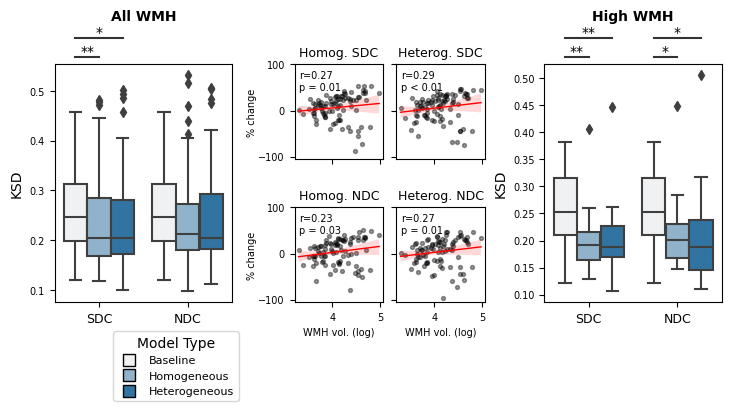

In [7]:
# Figure 3C-E
model_types = ["baseline", "homogeneous", "heterogeneous"]
model_names = ["Baseline", "Homogeneous", "Heterogeneous"]

tick_fontsize = 7
title_fontsize = 10

fig = plt.figure(figsize=(7.2, 4), constrained_layout=True)
axs = fig.subplot_mosaic(
    [["L", "M1", "M2", "R"], ["L", "M3", "M4", "R"]],
    gridspec_kw={"width_ratios": [1, 0.5, 0.5, 1], "height_ratios": [0.5, 0.5]},
)

# Plot comparison in all wmh subjects
plot_comparison(df_model_comparison_wmh_long, "phfcd_ks", axs["L"])
sns.regplot(
    data=df_model_diffs,
    x="wmh_log",
    y="phfcd_ks_diff_base_G",
    ax=axs["M1"],
    color="k",
    scatter_kws={"s": 8, "alpha": 0.4},
    line_kws={"color": "red", "linewidth": 1},
)
sns.regplot(
    data=df_model_diffs,
    x="wmh_log",
    y="phfcd_ks_diff_base_disconn",
    ax=axs["M2"],
    color="k",
    scatter_kws={"s": 8, "alpha": 0.4},
    line_kws={"color": "red", "linewidth": 1},
)
sns.regplot(
    data=df_model_diffs,
    x="wmh_log",
    y="phfcd_ks_diff_base_a",
    ax=axs["M3"],
    color="k",
    scatter_kws={"s": 8, "alpha": 0.4},
    line_kws={"color": "red", "linewidth": 1},
)
sns.regplot(
    data=df_model_diffs,
    x="wmh_log",
    y="phfcd_ks_diff_base_het",
    ax=axs["M4"],
    color="k",
    scatter_kws={"s": 8, "alpha": 0.4},
    line_kws={"color": "red", "linewidth": 1},
)

# Write the correlation values corrected by Age
write_corr_pval(
    df_model_diffs,
    "wmh_log",
    "phfcd_ks_diff_base_G",
    axs["M1"],
    tick_fontsize,
    correct_age=True,
)
write_corr_pval(
    df_model_diffs,
    "wmh_log",
    "phfcd_ks_diff_base_disconn",
    axs["M2"],
    tick_fontsize,
    correct_age=True,
)
write_corr_pval(
    df_model_diffs,
    "wmh_log",
    "phfcd_ks_diff_base_a",
    axs["M3"],
    tick_fontsize,
    correct_age=True,
)
write_corr_pval(
    df_model_diffs,
    "wmh_log",
    "phfcd_ks_diff_base_het",
    axs["M4"],
    tick_fontsize,
    correct_age=True,
)
# Plot comparison in high wmh subjects
plot_comparison(df_model_comparison_high_wmh_long, "phfcd_ks", axs["R"])

axs["L"].set_xticklabels(["SDC", "NDC"])
axs["L"].tick_params(axis="y", which="major", labelsize=tick_fontsize)
axs["L"].tick_params(axis="x", which="major", labelsize=tick_fontsize + 2)
axs["L"].set_xlabel("")

axs["M1"].set_title("Homog. SDC", fontsize=tick_fontsize + 2)
axs["M1"].set_ylabel(r"% change", fontsize=tick_fontsize, labelpad=1)
axs["M1"].set_xlabel("")
axs["M1"].set_xticklabels("")
axs["M1"].tick_params(axis="both", which="major", labelsize=tick_fontsize)

axs["M2"].set_title("Heterog. SDC", fontsize=tick_fontsize + 2)
axs["M2"].set_ylabel(r"% change", fontsize=tick_fontsize)
axs["M2"].set_xlabel("")
axs["M2"].set_ylabel("")
axs["M2"].set_xticklabels("")
axs["M2"].set_yticklabels("")
axs["M2"].tick_params(axis="both", which="major", labelsize=tick_fontsize)

axs["M3"].set_title("Homog. NDC", fontsize=tick_fontsize + 2)
axs["M3"].set_ylabel(r"% change", fontsize=tick_fontsize, labelpad=1)
axs["M3"].set_xlabel("WMH vol. (log)", fontsize=tick_fontsize)
axs["M3"].tick_params(axis="both", which="major", labelsize=tick_fontsize)

axs["M4"].set_title("Heterog. NDC", fontsize=tick_fontsize + 2)
axs["M4"].set_ylabel("")
axs["M1"].set_ylim(-105, 100)
axs["M2"].set_ylim(-105, 100)
axs["M3"].set_ylim(-105, 100)
axs["M4"].set_ylim(-105, 100)
axs["M4"].set_yticklabels("")
axs["M4"].set_xlabel("WMH vol. (log)", fontsize=tick_fontsize)
axs["M4"].tick_params(axis="both", which="major", labelsize=tick_fontsize)

axs["R"].set_title("High WMH", y=1.15, fontsize=title_fontsize, fontweight="bold")
axs["R"].set_xticklabels(["SDC", "NDC"])
axs["R"].tick_params(axis="y", which="major", labelsize=tick_fontsize)
axs["R"].tick_params(axis="x", which="major", labelsize=tick_fontsize + 2)
axs["R"].set_xlabel("")

axs["L"].set_title("All WMH", y=1.15, fontsize=title_fontsize, fontweight="bold")
# # Create a legend with model types and colors
colors = [patch.get_facecolor() for patch in axs["L"].patches][:-4:2]
legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        label=parm_type,
        markerfacecolor=color,
        markersize=8,
        markeredgecolor="black",
    )
    for parm_type, color in zip(model_names, colors)
]
axs["L"].legend(
    handles=legend_elements,
    title="Model Type",
    bbox_to_anchor=[0.3, -0.1],
    fontsize=8,
    title_fontsize=10,
)
fig.savefig(FIG_DIR / "Fig3C.png", dpi=700)

In [8]:
# Load the random models
df_model_comparison_rand_wmh_long = prepare_group_df_for_plotting(
    all_wmh_subjs, is_random=True
)
df_model_rand_vs_non_rand = pd.concat(
    [df_model_comparison_wmh_long, df_model_comparison_rand_wmh_long]
)

In [9]:
# It doesn't make sense to compare the baseline to a random so we drop it
df_plotting_random = (
    df_model_rand_vs_non_rand[df_model_rand_vs_non_rand["model_type"] != "baseline"]
    .copy()
    .reset_index(drop=True)
)
# The format for plotting is slightly different from before, so we create a column combining the parameter type and the model type
df_plotting_random["homo_het"] = np.where(
    df_plotting_random["model_type"].str.contains("homogeneous"),
    df_plotting_random["parm_type"] + "_homogeneous",
    df_plotting_random["parm_type"] + "_heterogeneous",
)
df_plotting_random["random"] = np.where(
    df_plotting_random["model_type"].str.contains("random"), "random", "not_random"
)
pvalues_comparisons_random = calculate_pvals_random_comparisons(df_plotting_random)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

sdc_heterogeneous_not_random vs. sdc_heterogeneous_random: Custom statistical test, P_val:2.813e-03
sdc_homogeneous_not_random vs. sdc_homogeneous_random: Custom statistical test, P_val:4.147e-02
bif_parm_homogeneous_not_random vs. bif_parm_homogeneous_random: Custom statistical test, P_val:5.630e-01
bif_parm_heterogeneous_not_random vs. bif_parm_heterogeneous_random: Custom statistical test, P_val:5.509e-02


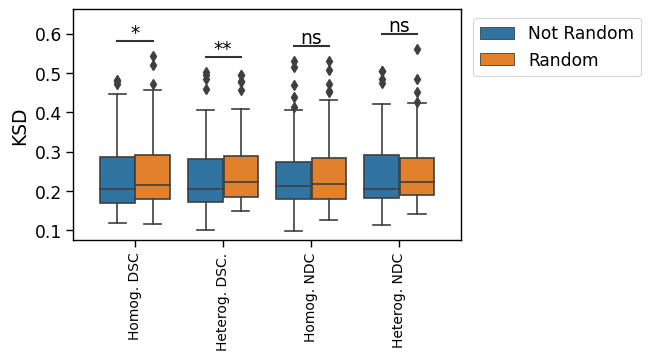

In [10]:
order = [
    "sdc_homogeneous",
    "sdc_heterogeneous",
    "bif_parm_homogeneous",
    "bif_parm_heterogeneous",
]
random_order = ["not_random", "random"]
pairs = [
    (("sdc_homogeneous", "random"), ("sdc_homogeneous", "not_random")),
    (("sdc_heterogeneous", "random"), ("sdc_heterogeneous", "not_random")),
    (("bif_parm_homogeneous", "random"), ("bif_parm_homogeneous", "not_random")),
    (("bif_parm_heterogeneous", "random"), ("bif_parm_heterogeneous", "not_random")),
]
with sns.plotting_context("paper", font_scale=1.4):
    fig, ax = plt.subplots(1, figsize=(5, 3))
    hue_plot_params = {
        "data": df_plotting_random,
        "x": "homo_het",
        "y": "phfcd_ks",
        "order": order,
        "hue": "random",
        "hue_order": random_order,
    }

    sns.boxplot(ax=ax, **hue_plot_params)
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(
        hide_non_significant=False, line_offset=0.1, line_height=0.0, text_offset=-1
    )
    annotator.set_pvalues(pvalues_comparisons_random)
    annotator.annotate()
    ax.set_ylabel("KSD")
    ax.set_xlabel("")
    ax.set_xticklabels(
        ["Homog. DSC", "Heterog. DSC.", "Homog. NDC", "Heterog. NDC"],
        fontsize=10,
        rotation=90,
    )

    legend = ax.legend(bbox_to_anchor=[1.01, 1])
    new_labels = ["Not Random", "Random"]
    for text, new_label in zip(legend.get_texts(), new_labels):
        text.set_text(new_label)

In [11]:
df_plotting_random.groupby(["parm_type", "model_type"]).describe()["phfcd_ks"].iloc[
    :, -4:-1
]

25%       50%       75%
parm_type model_type                                        
bif_parm  heterogeneous         0.181552  0.205054  0.292410
          heterogeneous_random  0.189241  0.223537  0.283385
          homogeneous           0.179626  0.211940  0.273418
          homogeneous_random    0.178370  0.216789  0.283813
sdc       heterogeneous         0.172149  0.204956  0.281346
          heterogeneous_random  0.185580  0.223919  0.288315
          homogeneous           0.169054  0.204074  0.285233
          homogeneous_random    0.180597  0.216185  0.291816

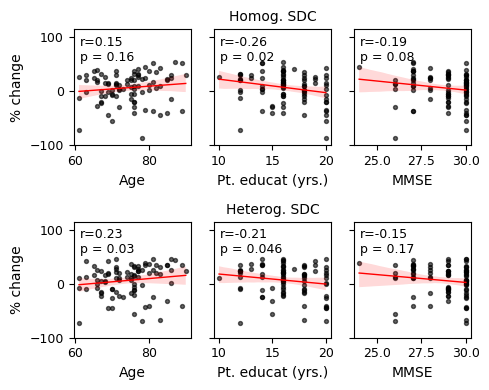

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(5, 4), sharey=True)

sns.regplot(
    data=df_model_diffs,
    x="Age",
    y="phfcd_ks_diff_base_G",
    ax=axs[0, 0],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="PTEDUCAT",
    y="phfcd_ks_diff_base_G",
    ax=axs[0, 1],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="MMSE",
    y="phfcd_ks_diff_base_G",
    ax=axs[0, 2],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)

sns.regplot(
    data=df_model_diffs,
    x="Age",
    y="phfcd_ks_diff_base_disconn",
    ax=axs[1, 0],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="PTEDUCAT",
    y="phfcd_ks_diff_base_disconn",
    ax=axs[1, 1],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="MMSE",
    y="phfcd_ks_diff_base_disconn",
    ax=axs[1, 2],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)


axs[0, 0].set_ylabel(r"% change")
axs[0, 1].set_ylabel("")
axs[0, 2].set_ylabel("")

axs[1, 0].set_ylabel(r"% change")
axs[1, 1].set_ylabel(
    "",
)
axs[1, 2].set_ylabel("")

axs[0, 1].set_xlabel("Pt. educat (yrs.)")
axs[1, 1].set_xlabel("Pt. educat (yrs.)")

axs[0, 0].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[0, 1].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[0, 2].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[1, 0].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[1, 1].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[1, 2].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)

# Slightly increase the axis to have more space for writing the correlation results
axs[0, 0].set_ylim(-100, 115)
axs[0, 1].set_ylim(-100, 115)
axs[0, 2].set_ylim(-100, 115)
axs[1, 0].set_ylim(-100, 115)
axs[1, 1].set_ylim(-100, 115)
axs[1, 2].set_ylim(-100, 115)

write_corr_pval(
    df_model_diffs,
    "Age",
    "phfcd_ks_diff_base_G",
    axs[0, 0],
    fontsize=9,
    correct_age=False,
)
write_corr_pval(
    df_model_diffs,
    "PTEDUCAT",
    "phfcd_ks_diff_base_G",
    axs[0, 1],
    fontsize=9,
    correct_age=True,
)
write_corr_pval(
    df_model_diffs,
    "MMSE",
    "phfcd_ks_diff_base_G",
    axs[0, 2],
    fontsize=9,
    correct_age=True,
)

write_corr_pval(
    df_model_diffs,
    "Age",
    "phfcd_ks_diff_base_disconn",
    axs[1, 0],
    fontsize=9,
    correct_age=False,
)
write_corr_pval(
    df_model_diffs,
    "PTEDUCAT",
    "phfcd_ks_diff_base_disconn",
    axs[1, 1],
    fontsize=9,
    correct_age=True,
)
write_corr_pval(
    df_model_diffs,
    "MMSE",
    "phfcd_ks_diff_base_disconn",
    axs[1, 2],
    fontsize=9,
    correct_age=True,
)

axs[0, 1].set_title("Homog. SDC", fontsize=title_fontsize)
axs[1, 1].set_title("Heterog. SDC", fontsize=title_fontsize)
fig.tight_layout()

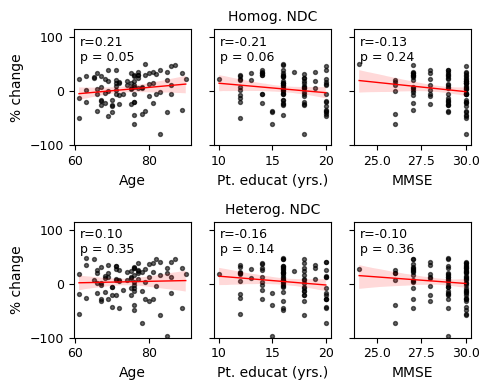

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(5, 4), sharey=True)

sns.regplot(
    data=df_model_diffs,
    x="Age",
    y="phfcd_ks_diff_base_a",
    ax=axs[0, 0],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="PTEDUCAT",
    y="phfcd_ks_diff_base_a",
    ax=axs[0, 1],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="MMSE",
    y="phfcd_ks_diff_base_a",
    ax=axs[0, 2],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)

sns.regplot(
    data=df_model_diffs,
    x="Age",
    y="phfcd_ks_diff_base_het",
    ax=axs[1, 0],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="PTEDUCAT",
    y="phfcd_ks_diff_base_het",
    ax=axs[1, 1],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="MMSE",
    y="phfcd_ks_diff_base_het",
    ax=axs[1, 2],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)


axs[0, 0].set_ylabel(r"% change")
axs[0, 1].set_ylabel("")
axs[0, 2].set_ylabel("")

axs[1, 0].set_ylabel(r"% change")
axs[1, 1].set_ylabel(
    "",
)
axs[1, 2].set_ylabel("")

axs[0, 1].set_xlabel("Pt. educat (yrs.)")
axs[1, 1].set_xlabel("Pt. educat (yrs.)")

axs[0, 0].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[0, 1].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[0, 2].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[1, 0].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[1, 1].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[1, 2].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)

# Slightly increase the axis to have more space for writing the correlation results
axs[0, 0].set_ylim(-100, 115)
axs[0, 1].set_ylim(-100, 115)
axs[0, 2].set_ylim(-100, 115)
axs[1, 0].set_ylim(-100, 115)
axs[1, 1].set_ylim(-100, 115)
axs[1, 2].set_ylim(-100, 115)

write_corr_pval(
    df_model_diffs,
    "Age",
    "phfcd_ks_diff_base_a",
    axs[0, 0],
    fontsize=9,
    correct_age=False,
)
write_corr_pval(
    df_model_diffs,
    "PTEDUCAT",
    "phfcd_ks_diff_base_a",
    axs[0, 1],
    fontsize=9,
    correct_age=True,
)
write_corr_pval(
    df_model_diffs,
    "MMSE",
    "phfcd_ks_diff_base_a",
    axs[0, 2],
    fontsize=9,
    correct_age=True,
)

write_corr_pval(
    df_model_diffs,
    "Age",
    "phfcd_ks_diff_base_het",
    axs[1, 0],
    fontsize=9,
    correct_age=False,
)
write_corr_pval(
    df_model_diffs,
    "PTEDUCAT",
    "phfcd_ks_diff_base_het",
    axs[1, 1],
    fontsize=9,
    correct_age=True,
)
write_corr_pval(
    df_model_diffs,
    "MMSE",
    "phfcd_ks_diff_base_het",
    axs[1, 2],
    fontsize=9,
    correct_age=True,
)

axs[0, 1].set_title("Homog. NDC", fontsize=title_fontsize)
axs[1, 1].set_title("Heterog. NDC", fontsize=title_fontsize)
fig.tight_layout()

In [14]:
def make_table_fitting_results(groupname, df_boxplot_compare_group, modality):
    df = pd.read_csv(
        SIM_DIR
        / f"group-{groupname}_data-simulated-{modality}_model-all_desc-df-fitting-comparison.csv",
        index_col=0,
    )
    test_name = df.columns[0]
    index_values = [
        "baseline",
        "homogeneous_a",
        "homogeneous_G",
        "heterogeneous",
        "disconnectivity",
    ]
    dict_comparison = {
        "homogeneous_a": "baseline_homogeneous_a",
        "homogeneous_G": "baseline_homogeneous_G",
        "heterogeneous": "baseline_heterogeneous",
        "disconnectivity": "baseline_disconnectivity",
    }
    df_comparisons = (
        df_boxplot_compare_group[["phfcd_ks", "model_type"]]
        .groupby("model_type")
        .describe()
        .iloc[:, -4:-1]
    )
    df_comparisons = df_comparisons.reset_index().droplevel(0, axis=1)
    df_comparisons.index = df_comparisons.iloc[:, 0]
    df_comparisons = df_comparisons.loc[index_values]
    df_comparisons = df_comparisons.iloc[:, 1:]
    list_pval = [np.nan]
    # df_comparisons = df_comparisons.loc[index_values]
    for k, v in dict_comparison.items():
        pval = df.loc[v, test_name]
        list_pval.append(pval.split("Stat")[0].strip().split(":")[1])
    df_comparisons["pval (BH significance)"] = list_pval
    return df_comparisons

In [15]:
import pandas as pd
import statsmodels.api as sm


def perform_linear_regression(df, y_col, x_cols):

    # Single variable linear regression
    df_univariate = pd.DataFrame()
    for x_col in x_cols:
        X = df[x_col]
        X = sm.add_constant(X)  # Add constant term
        y = df[y_col]
        model = sm.OLS(y, X).fit()
        results_as_html = model.summary().tables[1].as_html()
        df_uni = pd.read_html(results_as_html, header=0, index_col=0)[0]
        df_univariate = pd.concat([df_univariate, df_uni])

    # Multivariate linear regression
    X = df[x_cols]
    X = sm.add_constant(X)  # Add constant term
    y = df[y_col]
    model = sm.OLS(y, X).fit()
    results_as_html = model.summary().tables[1].as_html()
    df_multivariate = pd.read_html(results_as_html, header=0, index_col=0)[0]

    return df_univariate, df_multivariate


uni_diff_base_G, multi_diff_base_G = perform_linear_regression(
    df_model_diffs, "phfcd_ks_diff_base_G", ["wmh_log", "Age", "PTEDUCAT", "MMSE"]
)
uni_diff_base_disconn, multi_diff_base_disconn = perform_linear_regression(
    df_model_diffs, "phfcd_ks_diff_base_disconn", ["wmh_log", "Age", "PTEDUCAT", "MMSE"]
)

In [16]:
df_amy_tau = pd.read_csv(UTL_DIR / "UPENNBIOMK_MASTER_FINAL_31Jan2024.csv")
df_amy_tau["PTID"] = "ADNI" + df_amy_tau["PTID"].str.replace("_", "")
df_amy_tau = df_amy_tau[df_amy_tau["PTID"].isin(df_petTOAD_pre["PTID"])].copy()
df_amy_tau["DRAWDATE"] = pd.to_datetime(df_amy_tau["EXAMDATE"])
# Merge based on 'RID' and date condition
df_merged = pd.merge(
    df_petTOAD_pre,
    df_amy_tau[["ABETA40", "ABETA42", "PTAU", "TAU", "PTID", "DRAWDATE"]],
    on="PTID",
)
df_merged = df_merged[
    (df_merged["DRAWDATE"] >= df_merged["Acq Date"] - pd.DateOffset(months=3))
    & (df_merged["DRAWDATE"] <= df_merged["Acq Date"] + pd.DateOffset(months=3))
]

df_merged["ABETA40"] = pd.to_numeric(df_merged["ABETA40"])
df_merged["ABETA42"] = pd.to_numeric(df_merged["ABETA42"])
df_merged["PTAU"] = pd.to_numeric(df_merged["PTAU"])
df_merged["TAU"] = pd.to_numeric(df_merged["TAU"])
df_merged["ABETA_ratio"] = df_merged["ABETA42"] / df_merged["ABETA40"]
df_model_diffs_bmrkr = pd.merge(
    df_model_diffs_wide, df_merged[["PTID", "TAU", "PTAU", "ABETA_ratio"]], on="PTID"
)

In [17]:
# Mass univariate analyses of biomarkers
uni_diff_base_G2, multi_diff_base_G2 = perform_linear_regression(
    df_model_diffs_bmrkr, "phfcd_ks_diff_base_G", ["TAU", "PTAU", "ABETA_ratio"]
)
uni_diff_base_disconn2, multi_diff_base_disconn2 = perform_linear_regression(
    df_model_diffs_bmrkr, "phfcd_ks_diff_base_disconn", ["TAU", "PTAU", "ABETA_ratio"]
)
uni_diff_base_a, multi_diff_base_a = perform_linear_regression(
    df_model_diffs_bmrkr, "phfcd_ks_diff_base_a", ["TAU", "PTAU", "ABETA_ratio"]
)
uni_diff_base_het, multi_diff_base_het = perform_linear_regression(
    df_model_diffs_bmrkr, "phfcd_ks_diff_base_het", ["TAU", "PTAU", "ABETA_ratio"]
)

In [18]:
# Mass univariate analyses of everything
df_super = pd.merge(
    df_model_diffs_bmrkr,
    df_petTOAD[["PTID", "Age", "MMSE", "high_wmh_bin", "wmh_log", "PTEDUCAT"]],
    on="PTID",
)
uni_diff_base_G2, multi_diff_base_G2 = perform_linear_regression(
    df_super,
    "phfcd_ks_diff_base_G",
    ["wmh_log", "Age", "PTEDUCAT", "MMSE", "TAU", "PTAU", "ABETA_ratio"],
)
uni_diff_base_disconn2, multi_diff_base_disconn2 = perform_linear_regression(
    df_super,
    "phfcd_ks_diff_base_disconn",
    ["wmh_log", "Age", "PTEDUCAT", "MMSE", "TAU", "PTAU", "ABETA_ratio"],
)
uni_diff_base_a, multi_diff_base_a = perform_linear_regression(
    df_super,
    "phfcd_ks_diff_base_a",
    ["wmh_log", "Age", "PTEDUCAT", "MMSE", "TAU", "PTAU", "ABETA_ratio"],
)
uni_diff_base_het, multi_diff_base_het = perform_linear_regression(
    df_super,
    "phfcd_ks_diff_base_het",
    ["wmh_log", "Age", "PTEDUCAT", "MMSE", "TAU", "PTAU", "ABETA_ratio"],
)

In [19]:
df_G = df_super.copy()
df_G["wmh_log_norm"] = (df_G["wmh_log"] - df_G["wmh_log"].min()) / (
    df_G["wmh_log"].max() - df_G["wmh_log"].min()
)
df_G["avg_G"] = best_G - 0.1 + (-0.7 * df_G["wmh_log_norm"])
uni_regression_with_G, multi_regression_with_G = perform_linear_regression(
    df_G, "avg_G", ["Age", "PTEDUCAT", "MMSE"]
)

In [20]:
df_G_all = load_model_results(G_DIR, "sdc", "homogeneous")
combo = df_G_all.groupby("PTID")["phfcd_ks"].min()
df = pd.DataFrame(combo).reset_index()
df_best_G = pd.merge(df, df_G_all, on=["PTID", "phfcd_ks"])
df_best_G = pd.merge(df_best_G, df_super, on="PTID")
# df_best_G = df_best_G[df_best_G["high_wmh_bin"] == "high_wmh"].copy()
df_best_G["wmh_log_norm"] = (df_best_G["wmh_log"] - df_best_G["wmh_log"].min()) / (
    df_best_G["wmh_log"].max() - df_best_G["wmh_log"].min()
)
df_best_G["best_G"] = (
    best_G + df_best_G["b"] + (df_best_G["w"] * df_best_G["wmh_log_norm"])
)
df_best_G["avg_G"] = best_G - 0.1 + (-0.7 * df_best_G["wmh_log_norm"])
df_best_G["diff_G"] = df_best_G["best_G"] - df_best_G["avg_G"]
uni_regression_with_diffs_best_G_avg_G, multi_regression_with_diffs_best_G_avg_G = (
    perform_linear_regression(df_best_G, "best_G", ["Age", "PTEDUCAT", "MMSE"])
)